In [24]:
import json
import math
import pandas as pd
from matplotlib import pyplot as plt

with open('data/individuals_1721540790.json', 'r') as file:
    data = json.load(file)

# Create a list to store the flattened data
flattened_data = []

# Iterate through each politician in the data
for politician in data:
    first_name = politician['first_name']
    last_name = politician['last_name']
    position = politician['position']
    
    # If the politician has stocks, create a row for each stock
    for stock in politician['stocks']:
        amount_avg = math.floor(sum(stock['amount']) / 2) if stock['amount'] else None
        flattened_data.append({
            "first_name": first_name,
            "last_name": last_name,
            "position": position,
            "transaction_date": stock['transaction_date'],
            "owner": stock['owner'],
            "ticker": stock['ticker'],
            "asset_name": stock['asset_name'],
            "asset_type": stock['asset_type'],
            "transaction_type": stock['transaction_type'],
            "amount": amount_avg,
            "comment": stock['comment']
        })

# Create a DataFrame from the flattened data
df = pd.DataFrame(flattened_data)
df.head()

,first_name,last_name,position,transaction_date,owner,ticker,asset_name,asset_type,transaction_type,amount,comment
0,Michael F,Bennet,Senator,03/28/2017,Self,RGC,Regal Entertainment Group,Stock,Sale (Partial),750000,None
1,Roy,Blunt,Senator,06/06/2022,Spouse,AMBP,Ardagh Metal Packaging S.A. Ordinary Shares,Stock,Purchase,75000,None
2,Roy,Blunt,Senator,09/27/2021,Spouse,NRDY,Nerdy Inc. Class A Common Stock,Stock,Purchase,8000,None
3,Roy,Blunt,Senator,11/11/2014,Spouse,MDLZ,"Mondelez International, Inc. (NASDAQ)",,Sale (Full),75000,None
4,Roy,Blunt,Senator,11/26/2019,Spouse,KHC,The Kraft Heinz Company,Stock Option,Sale (Full),8000,Option received as part of compensation.


In [25]:
# Filter asset type by Stock Options
df['transaction_date'] = pd.to_datetime(df['transaction_date'], format='%m/%d/%Y')

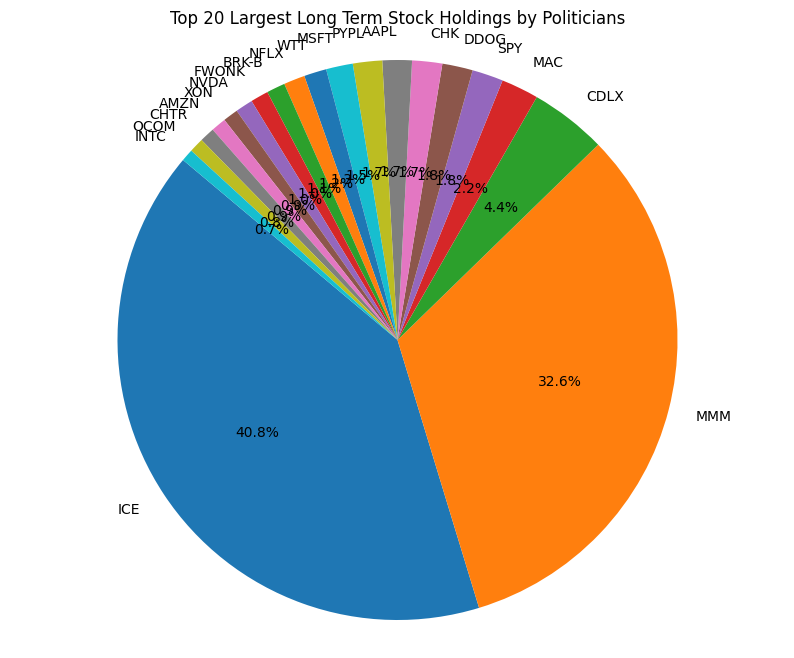

In [41]:
stock_df = df[df['asset_type'] == 'Stock']
# Identify stocks with both "Purchase" and "Sale (Full)" transactions by the same politician
duplicates = stock_df[stock_df.duplicated(subset=['first_name', 'last_name'], keep=False)]

# Step 2: Identify the criteria for removal
# We need to identify pairs where one row has 'P' and the other has 'S'
criteria_to_remove = duplicates.groupby(['first_name', 'last_name'])['transaction_type'].apply(lambda x: set(x) == {'Purchase', 'Sale (Partial)'}).reset_index()
criteria_to_remove = criteria_to_remove[criteria_to_remove['transaction_type']]

# Step 3: Merge with original duplicates to get the full rows that need to be removed
rows_to_remove = duplicates.merge(criteria_to_remove[['first_name', 'last_name']], on=['first_name', 'last_name'], how='inner')

# Step 4: Remove these rows from the original DataFrame
filtered_df = stock_df[~stock_df.index.isin(rows_to_remove.index)]

# Calculate the accumulated amount for each stock holding
holdings = filtered_df.groupby('ticker')['amount'].sum().reset_index()

# Sort by amount to get the largest holdings
holdings = holdings.sort_values(by='amount', ascending=False)

# Keep only the top 20 holdings
top_holdings = holdings.head(20)

# Plot the largest holdings in a pie chart
plt.figure(figsize=(10, 8))
plt.pie(top_holdings['amount'], labels=top_holdings['ticker'], autopct='%1.1f%%', startangle=140)
plt.title('Top 20 Largest Long Term Stock Holdings by Politicians')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [36]:
df[df['asset_type']=='Cryptocurrency']


,first_name,last_name,position,transaction_date,owner,ticker,asset_name,asset_type,transaction_type,amount,comment
5164,Rafael E,Cruz,Senator,2022-01-25,Self,BTC,Bitcoin,Cryptocurrency,Purchase,32500,None
5171,Rafael E,Cruz,Senator,2022-01-25,Self,BTC,Bitcoin,Cryptocurrency,Purchase,32500,None
6293,Cynthia M,Lummis,Senator,2021-08-16,Self,BTC,Bitcoin,Cryptocurrency,Purchase,75000,None
11171,Patrick J,Toomey,Senator,2021-06-14,Self,ETHE,Grayscale Ethereum Trust (ETH),Cryptocurrency,Purchase,8000,None
11172,Patrick J,Toomey,Senator,2021-06-15,Self,GBTC,Grayscale Bitcoin Trust (BTC),Cryptocurrency,Purchase,8000,None


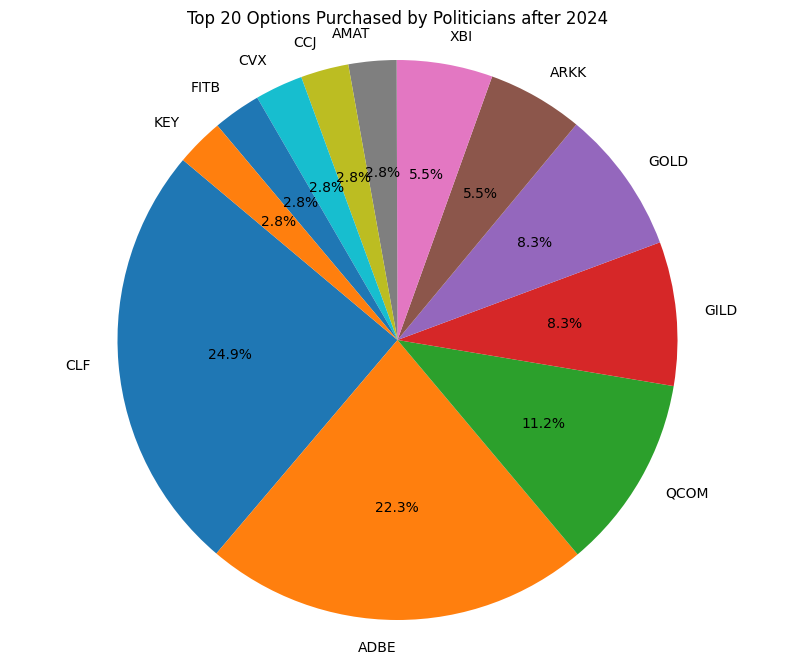

In [44]:
cutoff_date = pd.to_datetime('2024-01-01')
options_df = df[(df['asset_type']=='Stock Option') & (df['transaction_date'] > cutoff_date)]

# Identify stocks with both "Purchase" and "Sale (Full)" transactions by the same politician
duplicates = stock_df[stock_df.duplicated(subset=['first_name', 'last_name'], keep=False)]
criteria_to_remove = duplicates.groupby(['first_name', 'last_name'])['transaction_type'].apply(lambda x: set(x) == {'Purchase', 'Sale (Partial)'}).reset_index()
criteria_to_remove = criteria_to_remove[criteria_to_remove['transaction_type']]

# Step 3: Merge with original duplicates to get the full rows that need to be removed
rows_to_remove = duplicates.merge(criteria_to_remove[['first_name', 'last_name']], on=['first_name', 'last_name'], how='inner')

# Step 4: Remove these rows from the original DataFrame
filtered_df = options_df[~options_df.index.isin(rows_to_remove.index)]

# Calculate the accumulated amount for each stock holding
holdings = filtered_df.groupby('ticker')['amount'].sum().reset_index()

# Sort by amount to get the largest holdings
holdings = holdings.sort_values(by='amount', ascending=False)

# Keep only the top 20 holdings
top_holdings = holdings.head(20)

# Plot the largest holdings in a pie chart
plt.figure(figsize=(10, 8))
plt.pie(top_holdings['amount'], labels=top_holdings['ticker'], autopct='%1.1f%%', startangle=140)
plt.title('Top 20 Options Purchased by Politicians after 2024')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()